### Joshua Lim - ML HW02

In [1]:
# Qn 1a
import numpy as np

csv = 'https://www.dropbox.com/s/oqoyy9p849ewzt2/linear.csv?dl=1'
data = np.genfromtxt(csv,delimiter =',')
X = data[:,1:]
Y = data[:,0]
   
vX = X[:10,:]
tX = X[10:,:]
vY = Y[:10]
tY = Y[10:]

print ('Shape of vX:', vX.shape)
print ('Shape of tX:', tX.shape)
print ('Shape of vY:', vY.shape)
print ('Shape of tY:', tY.shape)

Shape of vX: (10, 4)
Shape of tX: (40, 4)
Shape of vY: (10,)
Shape of tY: (40,)


In [2]:
# Qn 1b
import theano
import theano.tensor as T
from theano import pp

penalty = 0.15

d = tX.shape[1]#dimension of feature vectors
n = tX.shape[0]#number of training samples
learn_rate = 0.5#learning rate for gradient descent

x = T.matrix(name='x')#feature matrix
y = T.vector(name='y')#response vector
w = theano.shared(np.zeros((d,1)),name='w')#model parameters

reg_risk = T.sum(w[:-1]*w[:-1])*penalty/2 #regularization risk. Ignore the offset 
emp_risk = T.sum((T.dot(x,w).T-y)**2)/2/n #empirical risk
total_risk = reg_risk + emp_risk
grad_risk = T.grad(total_risk,wrt=w) #gradient of the risk
train_model = theano.function(inputs=[],
                            outputs=total_risk,
                            updates=[(w,w-learn_rate*grad_risk)],
                            givens={x:tX, y:tY})

n_steps=50
for i in range(n_steps):
    train_model()
print(np.ravel(w.get_value()))


[-0.53590673  1.20293332  0.04334569 -1.85492455]


In [3]:
#Qn 1c
from scipy.optimize import fmin_l_bfgs_b as minimize

def costgrad(w, x, y):
    n = x.shape[0]
    penalty = 0.15
    reg_risk = np.sum(w[:-1]*w[:-1])*penalty/2
    emp_risk = np.sum((np.dot(x,w).flatten()-y)**2)/2/n
    total_risk = reg_risk + emp_risk
    grad_risk = (penalty * np.append(w[:-1],0)) + (np.dot(np.dot(np.transpose(x),x),w)/n) - (np.dot(np.transpose(x),y)/n)
    return total_risk,grad_risk

w = np.zeros((d,1))
optx,cost,messages = minimize(costgrad,w,args=[tX, tY])
print (optx)

[-0.53591305  1.20293347  0.04332715 -1.85492236]


In [4]:
#Qn 1d

def ridge_regression(tX, tY, l):
    n,d = tX.shape
    eye_mat = np.eye(d)
    eye_mat[-1,-1] = 0 #set last feature to zero
    reg = n * l * eye_mat
    
    X_trans = np.transpose(tX)
    inv = np.linalg.inv(np.dot(X_trans,tX) + reg)
    X_ = np.dot(inv,X_trans)
    theta = np.dot(X_,tY)
    return theta

print (ridge_regression(tX,tY,0.15))

[-0.53590673  1.20293332  0.04334568 -1.85492455]


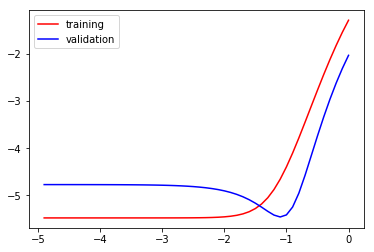

The optimal lambda value is: 0.0794328234724 or 10^(-1.1)


In [5]:
#Qn 1e
import matplotlib.pyplot as plt

tn = tX.shape[0]
vn = vX.shape[0]
tloss = []
vloss = []
index = -np.arange(0,5,0.1)
for i in index:
    w = ridge_regression(tX,tY,10**i)
    tloss = tloss+[np.sum((np.dot(tX,w)-tY)**2)/tn/2]
    vloss = vloss+[np.sum((np.dot(vX,w)-vY)**2)/vn/2]

plt.plot(index,np.log(tloss),'r',label = 'training')
plt.plot(index,np.log(vloss),'b',label = 'validation')
plt.legend(loc='upper left')
plt.show()
print ('The optimal lambda value is:', pow(10,index[np.asarray(vloss).argmin()]), 'or 10^('+str(index[np.asarray(vloss).argmin()])+')')

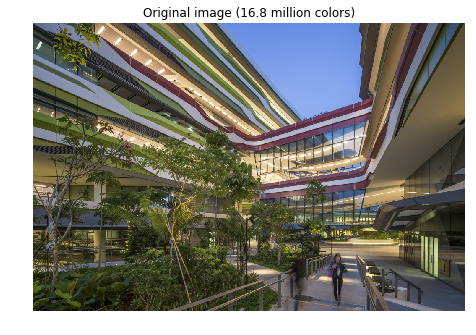

In [6]:
#Qn 2

import numpy.random as rng
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

n_colors = 32
pic = 'https://www.dropbox.com/s/bmwwfct2qxjfje4/sutd.png?dl=1'
img = mpimg.imread(pic)
img = img[:,:,:3]
w, h, d = tuple(img.shape)
image_array = np.reshape(img, (w * h, d))

def recreate_image(palette, labels, w, h):
    d = palette.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = palette[labels[label_idx]]
            label_idx += 1
    return image

#Original Image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (16.8 million colors)')
plt.imshow(img)
plt.show()


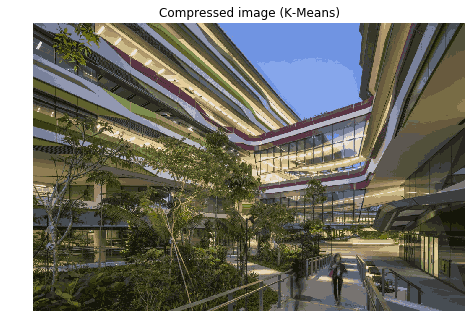

In [7]:
#Qn 2a
sample = image_array[rng.permutation(w * h)[:1000]] #1000 Random pixel samples
model = KMeans(n_clusters=32).fit(sample)
kmeans_palette = model.cluster_centers_ #Colour Palette

kmeans_labels = model.predict(image_array)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Compressed image (K-Means)')
plt.imshow(recreate_image(kmeans_palette, kmeans_labels, w, h))
plt.show()

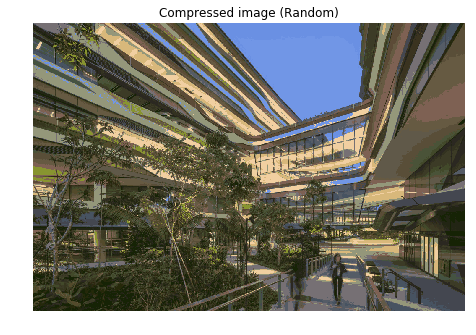

In [8]:
#Qn 2b
random_palette = image_array[rng.permutation(w * h)[:32]] #32 Random pixel samples for palette
random_labels = pairwise_distances_argmin(image_array,random_palette)

plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Compressed image (Random)')
plt.imshow(recreate_image(random_palette, random_labels, w, h))
plt.show()

## Qn 2c

\begin{align*}
    \sum_{i=1}^m ||x - z||^2 &= \sum_{i=1}^m x^2 - 2xz + ||z||^2\\
    \frac{d}{dx} &= \sum_{i=1}^m 2x - 2z = 0\\
    2zm &= \sum_{i=1}^m 2x\\
    z &= \frac{1}{m} \sum_{i=1}^m x\\
   \\
\end{align*}

In [9]:
# Qn 3
import pandas as pd
from IPython.display import display

train = 'https://www.dropbox.com/s/cfr26dayxhu2vws/titanic_train.csv?dl=1'
test = 'https://www.dropbox.com/s/48siej0sk7jlcx5/titanic_test.csv?dl=1'
X_data = pd.read_csv(train)
X_test = pd.read_csv(test)
X_valid = X_data.sample(frac=0.2,random_state=200)
X_train = X_data.drop(X_valid.index)
Y_data = X_data["Survived"]
Y_valid = X_valid["Survived"]
Y_train = X_train["Survived"]
ID_test = X_test["PassengerId"]

# display(X_data.head())
# display(X_data.describe())
# display(X_test.head())
# display(X_test.describe())

def preprocess(df):
    df.drop(["Survived"],axis=1,inplace=True,errors="ignore")
    df.drop(["PassengerId","Name","Ticket","Cabin"],axis=1,inplace=True)

    df["Embarked"].fillna(df["Embarked"].mode()[0],inplace=True)
    df["Fare"].fillna(df["Fare"].median(),inplace=True)
    df["Age"].fillna(df["Age"].mean(),inplace=True)

    df = df.join(pd.get_dummies(df["Embarked"]))
    df.drop(["Embarked"],axis=1,inplace=True)
    df = df.join(pd.get_dummies(df["Sex"]))
    df.drop(["Sex"],axis=1,inplace=True)
    df = df.join(pd.get_dummies(df["Pclass"]))
    df.drop(["Pclass"],axis=1,inplace=True)

    df.loc[df.SibSp > 0 ,"Family"] = 1
    df.loc[df.Age < 16, "Child"] = 1

    df["Family"].fillna(0,inplace=True)
    df["Child"].fillna(0,inplace=True)
    
    return df



In [10]:
# Qn 3a
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_data = preprocess(X_data)
X_test = preprocess(X_test)
display(X_train.head())

,Age,SibSp,Parch,Fare,C,Q,S,female,male,1,2,3,Family,Child
0,22.000000,1,0,7.2500,0,0,1,0,1,0,0,1,1.0,0.0
2,26.000000,0,0,7.9250,0,0,1,1,0,0,0,1,0.0,0.0
3,35.000000,1,0,53.1000,0,0,1,1,0,1,0,0,1.0,0.0
4,35.000000,0,0,8.0500,0,0,1,0,1,0,0,1,0.0,0.0
5,29.449243,0,0,8.4583,0,1,0,0,1,0,0,1,0.0,0.0


In [11]:
# Qn 3b
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,Y_train)
print("Model score:",model.score(X_valid,Y_valid))

Model score: 0.780898876404


In [12]:
# Qn 3c
model2 = LogisticRegression()
model2.fit(X_data,Y_data)
print("Model parameters:", model2.coef_)
print("Intercept value:", model2.intercept_)

Model parameters: [[-0.02377991 -0.78116277 -0.18699147  0.00343958  0.21672421  0.29677386
  -0.11488855  1.51420057 -1.11559106  1.03356896  0.21482537 -0.84978482
   0.85645454  1.2537208 ]]
Intercept value: [ 0.39860951]


In [13]:
# Qn 3d
Y_test = model2.predict(X_test)
ans = pd.DataFrame({"PassengerId":ID_test,"Survived":Y_test})
ans.to_csv("submit.csv", index=False)
print("Kaggle ID: https://www.kaggle.com/limwenyao")
print("Competition Score: 0.77511")

Kaggle ID: https://www.kaggle.com/limwenyao
Competition Score: 0.77511
